# Measuring  the acoustic force field of an Acoustic Levitator (AL) with an Optical Trap (OT)

This notebook contains some of the main results of my Physics degree thesis project.  
The experiemntal work (data collection) was performed in the laboratory of optical levitation at the Uiversity of Gothenburg, Gothenburg, Sweden.

In [ ]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)

from scipy import optimize  #fitting
from scipy import signal    #filters and find peaks
from scipy.fft import fft, fftfreq

from pathlib import Path    #Access files and file-names easily 
from nptdms import TdmsFile    #Working with TDMS (LabView) files 

pathlib tutorial: https://pbpython.com/pathlib-intro.html

In [101]:
Path.cwd()

PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis')

## Data colection
Several experiments were performed and the data aquired was stored in different folders corresponding to the month on which they were performed.  
The experimental data was acquired through different sensors and apparatus and collected together in real time by a LabView program which outputs a **.tdms** file with all the data from one experiment.  
Here we explore the content of the August 2021 folder.

In [3]:
# Search the tdms files
data_folder = Path("/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021")
files_to_open=list(data_folder.glob('*.tdms')) #list with all the .tdms files' paths in the folder

files_to_open

[PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_07.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_rotations.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_10.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_06.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_01.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_03.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_02.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_05.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_09.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_08.tdms'),
 PosixPath('/Users/pablohermun/Tesis/Tesis_Analysis/Data/08-2021/AOT_04.tdms')]

Here we are mostly interested in exploring the files AOT_08, AOT_09 and AOT_10.  
The following Lab Notes includes some important faccts of these experiments.

### Lab Notes

Optical levitation trap with a $40 mm$ lens in a semi-opened chamber, in order to have a free propagation of the acoustic waves, produced by an acoustic levitator (AT), in it.

Particles trapped: $SiO_2$ (silica) particle of $24.82 \mu m$ diameter and density $1.85g/cm^3$.

Sometimes the laser power starts at 85% but then its maintained at 70%.

The AT voltage (V) is the main (independent) variable. 

I started to measure the peak to peak voltage (Vpp) with the LabViwe program. Its sampling rate is 1 per 200 V data points


#### Data exploration: 

#### AOT_8.tdms
- Good measurement =)
- At the begining the lamp was on, and noise reduced when turned off

#### AOT_9.tdms
- Bad measurement and the PSD was set a little weirdly

#### AOT_10.tdms

Some conclusions were draw from an early exploration of the data in the files of interest, which lead to **centering the atention on AOT_08** for the rest of this notebook.

In [4]:
# Explore the parts of the Path object for later use
file = -2 # File of interest
print(files_to_open[file].parts)
# Path object .stem -> file name

('/', 'Users', 'pablohermun', 'Tesis', 'Tesis_Analysis', 'Data', '08-2021', 'AOT_08.tdms')


[<TdmsGroup with path /'SOT'>]

## Loading the data
TDMS files organize data in 'groups' which contain 'channels'.  
In our case all the data is in the first (and only) group.  
Each channel contains the data of one of the measured variables.

In [ ]:
# Load tdms data and display the groups
tdms_data = TdmsFile(files_to_open[file]) #tdms (LabView) data of AOT_08
tdms_data.groups()

In [5]:
# Explore groups and channels of file
tdms_groups = tdms_data.groups()
print(tdms_data['SOT'].channels,'\n')
    
print(type(tdms_groups),'\n')

tdms_channels = tdms_groups[0].channels()
print(tdms_channels)

tdms_channels[1].properties

<bound method TdmsGroup.channels of <TdmsGroup with path /'SOT'>>
<class 'list'>
[<TdmsChannel with path /'SOT'/'YDiff'>, <TdmsChannel with path /'SOT'/'XDiff'>, <TdmsChannel with path /'SOT'/'Sum'>, <TdmsChannel with path /'SOT'/'ATx'>, <TdmsChannel with path /'SOT'/'ATy'>, <TdmsChannel with path /'SOT'/'ATz'>, <TdmsChannel with path /'SOT'/'P'>, <TdmsChannel with path /'SOT'/'V'>, <TdmsChannel with path /'SOT'/'V (Peak to Peak)'>]


OrderedDict([('wf_start_time', numpy.datetime64('2021-08-31T09:09:00.682850')),
             ('wf_start_offset', 0.0),
             ('wf_increment', 0.001),
             ('wf_samples', 200),
             ('NI_ChannelName', 'XDiff'),
             ('NI_UnitDescription', 'Volts'),
             ('unit_string', 'Volts')])

Fortunately the data can be directly loaded into a **pandas dataframe**.

In [6]:
df0=tdms_groups[0].as_dataframe(time_index=True)
df0

,YDiff,XDiff,Sum,ATx,ATy,ATz,P,V,V (Peak to Peak)
0.000,-0.392112,-0.012797,2.549393,47.9795,3.64205,21.0,0.279520,0.001254,0.002960
0.001,-0.392901,-0.013400,2.508279,47.9795,3.64205,21.0,0.279849,0.002241,0.003289
0.002,-0.391834,-0.012338,2.510910,47.9795,3.64205,21.0,0.279520,0.001583,0.002960
0.003,-0.391782,-0.013145,2.606954,47.9795,3.64205,21.0,0.279520,0.001583,0.002631
0.004,-0.391570,-0.012718,2.642807,47.9795,3.64205,21.0,0.279520,0.000925,0.002631
...,...,...,...,...,...,...,...,...,...
2215.995,0.090000,-0.209765,0.061447,47.9795,3.64205,21.0,0.305176,2.454007,NaN
2215.996,0.084647,-0.177647,0.061447,47.9795,3.64205,21.0,0.305176,-3.413263,NaN
2215.997,0.077632,-0.236812,0.062762,47.9795,3.64205,21.0,0.304518,2.152717,NaN
2215.998,0.073548,-0.192674,0.061775,47.9795,3.64205,21.0,0.305176,-1.751888,NaN


All the variables are recorded as time series with the same sampling rate except the V(Peak to peak) variable, which is computed from the V channel every 200 samples.  
That is why the last column in df has fewer entries.

In [7]:
df0.count()

YDiff               2216000
XDiff               2216000
Sum                 2216000
ATx                 2216000
ATy                 2216000
ATz                 2216000
P                   2216000
V                   2216000
V (Peak to Peak)      11080
dtype: int64

### ROUGH DATA EXPLORATION

Constant ATx: 47.9795
Constant ATy: 3.64205
Constant ATz: 21.0


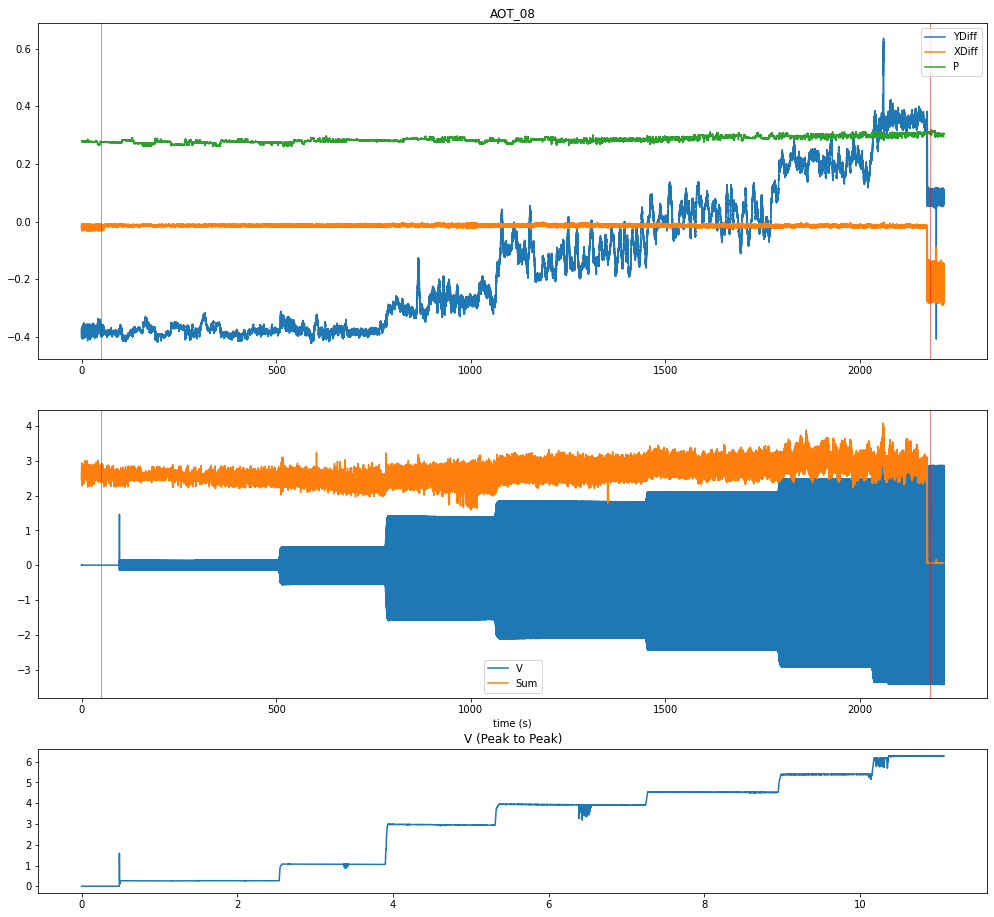

In [8]:
# First look at data

try: # if re-reunning after ini and fin have been changed
    print(f'ini={ini}\nfin={fin}')
except Exception:
    # Get rid of undesired initial and final consitions
    ini = 50 # Cutting lamp noise
    fin = 2180.0 # Cutting "falled particle"

# Plotting separately for different scales
fig, ax = plt.subplots(3, figsize=(17, 16), gridspec_kw={'height_ratios': [7,6,3]})

ax[0].set_title(files_to_open[file].stem)
for label, data in df0[['YDiff', 'XDiff','ATx', 'ATy', 'ATz', 'P']].iteritems():
    # Dont plot constant variables
    if data.max() == data.min():
        print(f"Constant {label}: {data.max()}")
    else:
        data.plot(ax = ax[0], label = label)
        ax[0].legend(loc = 'upper right')

df0["V"].plot(ax = ax[1])
df0["Sum"].plot(ax = ax[1])
ax[1].set_xlabel("time (s)")
ax[1].legend(["V", "Sum"])
for i in [0,1]:
    ax[i].axvline(ini, color = 'green', linewidth = 0.5)
    ax[i].axvline(fin, color = 'red', linewidth = 0.5)

df0["V (Peak to Peak)"].plot(ax = ax[2])
ax[2].set_title("V (Peak to Peak)")
plt.show()

## Data treatment
To calculate the **real position** of the light spot on the PSD we use the formulas from https://www.thorlabs.com/thorproduct.cfm?partnumber=PDP90A
    $$ X=\frac{L_x \Delta x}{2SUM}, \quad Y=\frac{L_y \Delta y}{2SUM} $$
    
Although the LABVIEW program already does the array division so $X_{Diff}=\frac{\Delta x}{SUM}$ and $Y_{Diff}=\frac{\Delta y}{SUM}$
    
Where $L_x=L_y=10mm$ are the dimensions of the PSD sensor.

Now to calculate the real particle movement we use the magnification factor from geometrical optics.
$$M=-\frac{b}{a}=\frac{f}{f-a}$$
Where $a\sim62\pm 1mm$ is the distance from the particle to the thin lens, $b=254\pm1mm$ (check) the distance from the lens to the PSD, and $f=50mm$ the focal point.

PSD spatial **resolution** (for the light spot) is $\Delta R=0.75 \mu m$, so for the particle displacement is $\mid \frac{\Delta R}{M}\mid$.

In [9]:
# Seting experimental parameters
a=62 
b=254
f=50

# Comparing different ways to compute the magnification
M2=f/(f-a)
M1=-b/a
M=(f-b)/f #This should be the most precise, since the error in b is less (if well measured)
res=-0.75E-6/M

sps=1000 # Samples per second in experiment

print(f'M={M}\nM1={M1}\nM2={M2}\nRes={res}')

M=-4.08
M1=-4.096774193548387
M2=-4.166666666666667
Res=1.8382352941176472e-07


In [10]:
# Transform position data to real position (units: m)
Lx=10E-3; Ly=10E-3
# Crop and 'magify' xydata
data_X=1/M*Lx/2*df0["XDiff"][ini:fin]
data_Y=1/M*Ly/2*df0["YDiff"][ini:fin]

### Plotting Vpp in the same time scale

In [11]:
def fill(unfilled, step, size): #function for filling up data with interpolation
    '''
    Takes (unfilled), an array of length (size/step)
    returns (filled), a (size) length array that has
    an (unfilled) value every (step) entries and the rest of values are interpolated.
    Also unfilled[0]=filled[0].
    '''
    if len(unfilled) != size/step:
        print("Incorrect dimensions")
        return
    
    filled = np.zeros(size)
    y = 0
    for x in range(len(unfilled)):
        while y < x*step:
            filled[y] = (unfilled[x] + unfilled[x-1]) /2 # Average interpolation
            y += 1
        if y == x*step: # data point
            filled[y] = unfilled[x]
            y += 1
    return filled

In [12]:
print(df0["V (Peak to Peak)"].dropna().shape[0]*200)
print(df0.shape[0])

2216000
2216000


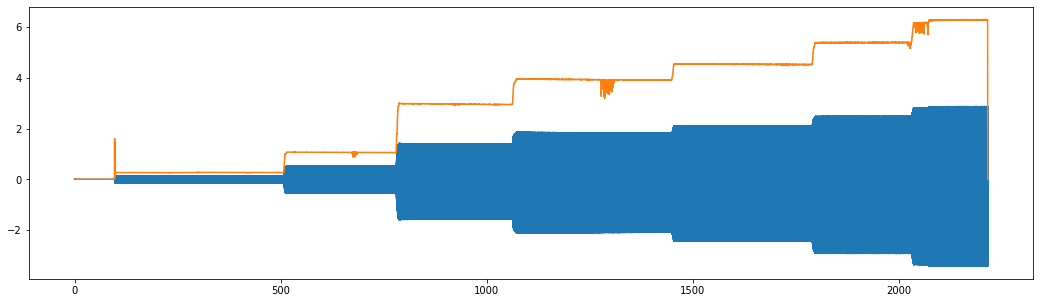

In [13]:
#V_peak-peak was measured (sampling is 1 for every 200 V-samples)
unfill = np.array(df0["V (Peak to Peak)"].dropna())
#We interpolate the points in between peak to peak measurments with a simple average
Vpp = fill(unfill, 200, df0.shape[0])

df0["V"].plot(figsize=(18,5))
plt.plot(df0.index,Vpp)
plt.show()

In [14]:
df0["Vpp"] = Vpp
df = pd.DataFrame({'X (m)':data_X,'Y (m)':data_Y,
                 "SUM (V)":df0["Sum"][ini:fin],
                 "Vpp (V)":df0["Vpp"][ini:fin]})

df.index.name = "t (s)"
df.count()

X (m)      2130001
Y (m)      2130001
SUM (V)    2130001
Vpp (V)    2130001
dtype: int64

In [15]:
df

,X (m),Y (m),SUM (V),Vpp (V)
t (s),,,,
50.000,0.000017,0.000458,2.448086,0.002631
50.001,0.000015,0.000458,2.477360,0.002960
50.002,0.000014,0.000459,2.494135,0.002960
50.003,0.000015,0.000459,2.498082,0.002960
50.004,0.000015,0.000459,2.498740,0.002960
...,...,...,...,...
2179.996,0.000262,-0.000110,0.061775,6.279406
2179.997,0.000258,-0.000131,0.061118,6.279406
2179.998,0.000269,-0.000103,0.061775,6.279406


In [16]:
df.to_csv("Results_AOT8.csv", index = True)

### Splitting in batches with (≈) constant Vpp

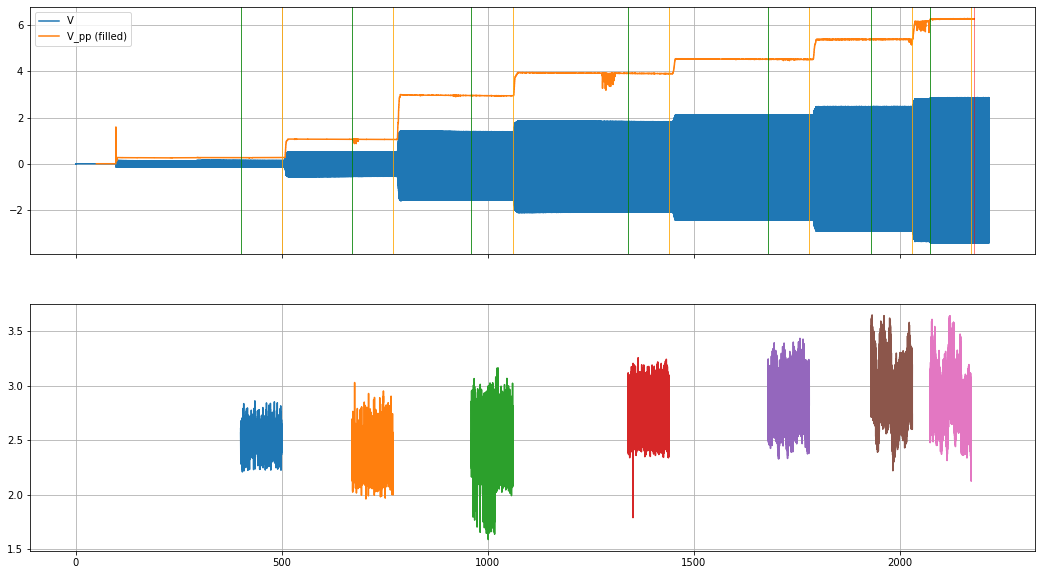

In [17]:
#Splitting the data in batches with constant V
batch_idx = (np.array([[330,430], #DEFINING BATCHES MANUALLY (same size)
           [600,700],
           [890,990],
           [1270,1370],
           [1610,1710],
           [1860,1960],
           [2003,2103]])+70)

#Plotting data and batches limits
fig, ax = plt.subplots(2, figsize=(18, 10), sharex=True)
df0["V"].plot(ax=ax[0], label='V')
df["Vpp (V)"].plot(ax=ax[0], label='V_pp (filled)')
for sec in batch_idx:
        ax[0].axvline((sec[0]),linewidth=0.8,color='green')
        ax[0].axvline((sec[1]),linewidth=0.8,color='orange')
ax[0].axvline(fin,color='red',linewidth=0.5)
ax[0].legend(loc='upper left')
ax[0].grid(which="major")

#Saving the data in batches (pandas series)
V_batches=[[] for _ in range(4)] #list with the X,Y,V,SUM data in batches (second index is for the no. of batch)
V_batches[2]=[df["Vpp (V)"][sec[0]:sec[1]] for sec in batch_idx]
V_batches[0]=[data_X[sec[0]:sec[1]] for sec in batch_idx]
V_batches[1]=[data_Y[sec[0]:sec[1]] for sec in batch_idx]
V_batches[3]=[df["SUM (V)"][sec[0]:sec[1]] for sec in batch_idx] #Used for angular momentum

#plotting each batch
for batch in range(7):
    ax[1].plot(V_batches[3][batch])#[batch] for batch in range(7)])
ax[1].grid(True)
plt.show()

In [18]:
print(f'ini = {ini}\nfin = {fin}')

ini = 50
fin = 2180.0


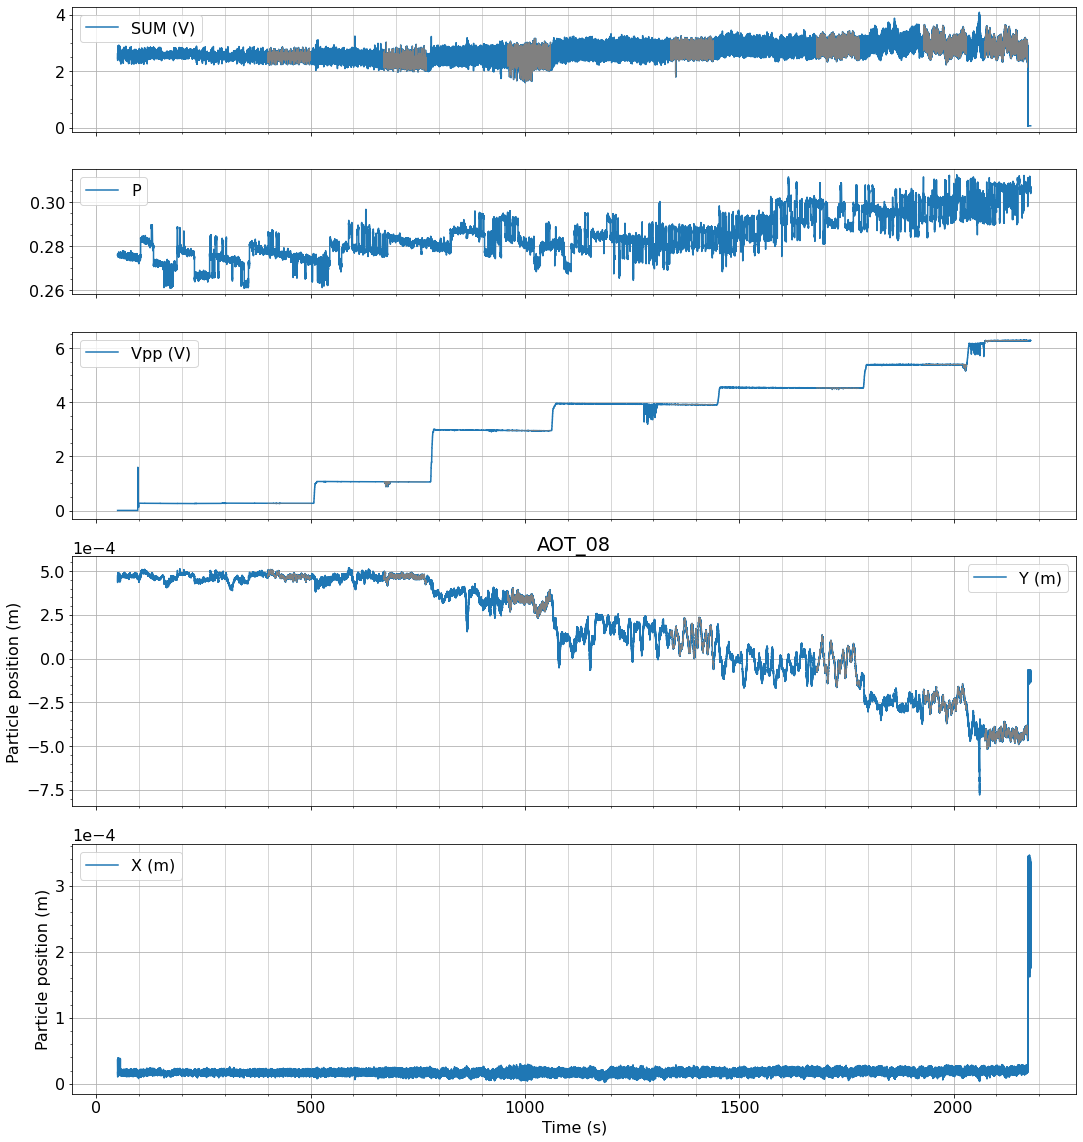

In [43]:
#Separate view of the data of interest with right units
#ini=50000
#fin=1000000
plots = ["SUM (V)", "P", "Vpp (V)", "X (m)", "Y (m)"]

fig, ax = plt.subplots(len(plots), figsize=(18, 20), gridspec_kw={'height_ratios': [2,2,3,4,4]}, sharex=True)
df[plots[0]].plot(ax=ax[0], label=plots[0])
df0[plots[1]][ini:fin].plot(ax=ax[1], label=plots[1])
df[plots[2]].plot(ax=ax[2], label=plots[2])
df[plots[4]].plot(ax=ax[3], label=plots[4])
#Real particle moovement data
ax[3].set_title(files_to_open[file].stem)
df[plots[3]].plot(ax=ax[4], label=plots[3])
plt.xlabel('Time (s)')
# Plot batches 
for bch in range(np.shape(batch_idx)[0]): #plot batch data on top of full data
    ax[0].plot(V_batches[3][bch],linewidth=0.5,color='gray') #batches data
    ax[2].plot(V_batches[2][bch],linewidth=0.5,color='gray') #batches data
    ax[3].plot(V_batches[1][bch],linewidth=0.5,color='gray') #batches data
# Customizing plots
for i in range(len(plots)):
    ax[i].grid(which='major')
    ax[i].grid(which='minor', axis='x', linewidth=0.5)
    ax[i].minorticks_on()
    ax[i].legend()
    if i in [3,4]:
        ax[i].set_ylabel('Particle position (m)')
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

# ANALYSIS

In [20]:
plt.rcParams.update({'font.size': 16})
colors_thesis=[r for r in plt.style.library['seaborn-deep']['axes.prop_cycle']]

In [30]:
print(colors_thesis)

[{'color': '#4C72B0'}, {'color': '#55A868'}, {'color': '#C44E52'}, {'color': '#8172B2'}, {'color': '#CCB974'}, {'color': '#64B5CD'}]


In [21]:
print(np.shape(batch_idx))
np.shape(V_batches)

(7, 2)


(4, 7, 100001)

## Acoustic potential (AOT_8)
Using Boltzmann distribution ?(i.e. approximating the stability positions as harmonic potentials) to obatain a potential https://www.nature.com/articles/s41598-021-89714-2 (supp. info)

In [22]:
def Boltz_U(p): #Computing the potential with Boltzmann distribution
    T=293 #Kelvin standard temperature
    kB=1.38064852E-23
    U= -kB*T*np.log(p)
    return U
def hist_to_xspace(limits):#Taking the centers of histogram bins to plot position
    xspace=[]
    for i in range(len(limits)-1):
        xspace.append((limits[i+1]+limits[i])/2)
    return xspace

In [23]:
#Making a histogram of the particle position in the selected period
binwidth=res*0.7
for batch in range(shape(batch_idx)[0]):
    fig, ax = plt.subplots(1,2,figsize=(16,3), gridspec_kw={'width_ratios': [1,2]})
    title0=f'Batch {batch+1} (Vp={np.mean(V_batches[2][batch]):.3f}±{np.std(V_batches[2][batch]):.4f})'
    fig.suptitle(title0)
    ax[0].hist(V_batches[0][batch],bins=np.arange(min(V_batches[0][batch]), max(V_batches[0][batch]) + binwidth, binwidth),label=('X'))
    ax[0].set_xlim(0.5E-5,3E-5)
    ax[0].legend()

    ax[1].hist(V_batches[1][batch],bins=np.arange(min(V_batches[1][batch]), max(V_batches[1][batch]) + binwidth, binwidth),label=('Y'), color='C1')
    ticklabel_format(axis="x", style="sci", scilimits=(-1,1))
    ax[1].set_xlim(-5.4E-4,5.3E-4)
    ax[1].set(xlabel='[m]')
    ax[1].legend()


NameError: name 'shape' is not defined

In [ ]:
#Making a histogram of the particle position in the selected period
#Making the bins similar to the resolution?
binwidth=res*0.7
for batch in range(shape(batch_idx)[0]):
    pX=np.histogram(V_batches[0][batch],bins=np.arange(min(V_batches[0][batch]), max(V_batches[0][batch]) + binwidth, binwidth)) #X
    pY=np.histogram(V_batches[1][batch],bins=np.arange(min(V_batches[1][batch]), max(V_batches[1][batch]) + binwidth, binwidth)) #Y

    xX=hist_to_xspace(pX[1])
    xY=hist_to_xspace(pY[1])
    #Plotting the potential energy of the particle

    UX=Boltz_U(pX[0])
    UY=Boltz_U(pY[0])

    fig, axs = plt.subplots(1,2,figsize=(15,4), gridspec_kw={'width_ratios': [1,2]})
    title1=f'Particle potential for batch {0+batch} (Δt={t[batch_idx[batch][0]]-t[batch_idx[batch][1]]:.0f} s)'
    fig.suptitle(title1)
    axs[0].plot(xX,UX,'o')
    axs[0].set_title('X potential')
    axs[0].set_xlim(0E-5,3.5E-5)
    
    axs[1].plot(xY,UY,'o',color='tab:orange')
    axs[1].set_title('Y potential')
    axs[1].set_xlim(-5.4E-4,5.3E-4)
    show()

## Position response 

In [22]:
#Arrays with averages and std deviations per batch
X_avg=[np.array([np.mean(V_batches[0][batch]) for batch in range(np.shape(batch_idx)[0])]),np.array([np.std(V_batches[0][batch]) for batch in range(np.shape(batch_idx)[0])])]
Y_avg=[np.array([np.mean(V_batches[1][batch]) for batch in range(np.shape(batch_idx)[0])]),np.array([np.std(V_batches[1][batch]) for batch in range(np.shape(batch_idx)[0])])]
V_avg=[np.array([np.mean(V_batches[2][batch]) for batch in range(np.shape(batch_idx)[0])]),np.array([np.std(V_batches[2][batch]) for batch in range(np.shape(batch_idx)[0])])]

### 2D history map with Vpp

In [572]:
def avg_batch(df, batchsize):
    '''Returns list with averages of df_col, taken over batchsize items'''
    avgd=[]
    for i in np.arange(df.shape[0], step=batchsize):
        avgd.append(df.iloc[i:i+batchsize].mean())
    return avgd

In [301]:
df.tail()

,X (m),Y (m),SUM (V),Vpp (V)
t (s),,,,
"2,179.9960",0.0003,-0.0001,0.0618,6.2794
"2,179.9970",0.0003,-0.0001,0.0611,6.2794
"2,179.9980",0.0003,-0.0001,0.0618,6.2794
"2,179.9990",0.0003,-0.0001,0.0628,6.2794
"2,180.0000",0.0002,-0.0001,0.0618,6.2755


The particle stbilizes (after turninig off light?) at t=56.468.
The particle gets knocked of from OT at t=2173.204.

In [623]:
def position_Vppcolor_map(start=56.468, stop=2173.204, ch_size=500, traject=False, batches=False):
    '''ch_size is the number of bins to skip in trajectory and average in scatter'''
    print('start:', start, 'stop:', stop)
    
    # Map average positions
    plt.scatter(avg_batch(df['X (m)'].loc[start:stop]*10e3, ch_size), avg_batch(df['Y (m)'].loc[start:stop]*10e3, ch_size), 
                alpha=0.6, c=avg_batch(df['Vpp (V)'].loc[start:stop],ch_size), cmap='Spectral_r')
    
    # Plot particle Trajectory
    if (traject==True):
        plt.plot(df['X (m)'].loc[start:stop].loc[1000*df.loc[start:stop].index%int(ch_size)==0]*10e6,
             df['Y (m)'].loc[start:stop].loc[1000*df.loc[start:stop].index%int(ch_size)==0]*10e3,
             lw=0.5, alpha=0.4)
    
    # Plot averaged position FROM BATCHES on top
    if batches==True:
        for batch in range(np.shape(batch_idx)[0]):
            plt.scatter(avg_batch(10e6 *pd.Series(np.array(V_batches[0][batch])),500), 
                    avg_batch(10e3 *pd.Series(np.array(V_batches[1][batch])),500), 
                    alpha = 0.4, c='gray')
    
    plt.xlabel('Particle X avg. position (mm)')
    plt.ylabel('Particle Y avg. position (mm)')
    # Color customization
    cbar = plt.colorbar(label='AL amplitude (V)')
    cbar.ax.set_yticks(np.around(V_avg[0],1))
    cbar.ax.set_yticklabels(np.around(V_avg[0],1))
    cbar.ax.invert_yaxis()

start: 56.468 stop: 2173.22


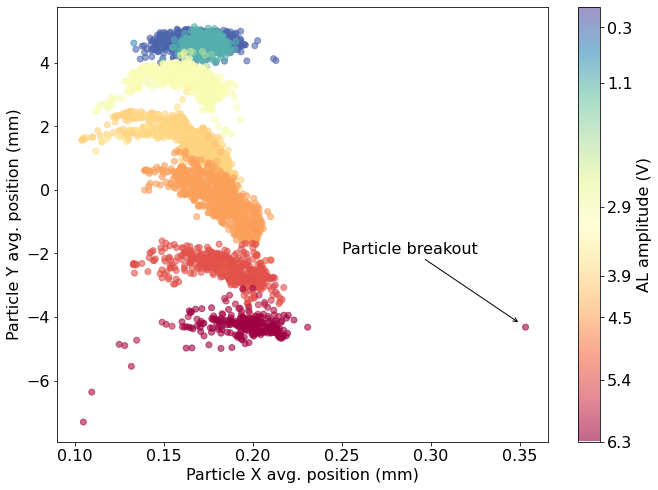

In [624]:
plt.figure(figsize=(11, 8))

position_Vppcolor_map(stop=2173.22, traject=False, batches=False)
plt.xlim(90e-3, None)

plt.annotate("Particle breakout",
            xy=(350e-3, -4.2), xycoords="data",
            xytext=(250e-3, -2), textcoords="data",
            arrowprops=dict(arrowstyle="->", mutation_scale=10, connectionstyle="arc3")
            )

plt.savefig('DVpp plots/DVppMap.pdf', bbox_inches='tight')
plt.show()

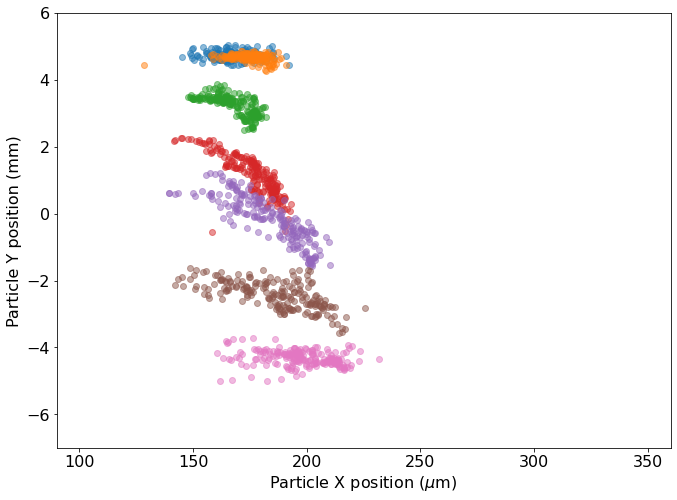

In [589]:
plt.figure(figsize=(11, 8))
for batch in range(np.shape(batch_idx)[0]):
    plt.scatter(avg_batch(10e6 *pd.Series(np.array(V_batches[0][batch])),500), 
                avg_batch(10e3 *pd.Series(np.array(V_batches[1][batch])),500), 
                alpha = 0.4, c='gray')
plt.xlabel('Particle X position ($\mu$m)')
plt.ylabel('Particle Y position (mm)')

plt.xlim(90,360)
plt.ylim(-7,6)
plt.show()

In [543]:
from matplotlib.animation import FuncAnimation
from IPython import display

In [102]:
def lin(x,m,b):
    return m*x+b
def quad(x,a,b):
    return a*x**2+b

parameters:[ 0.86962658 14.17855065]
error: [0.07677948 0.35945263]


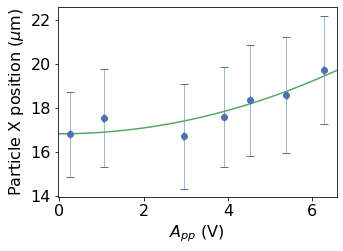

parameters:[-0.22945505  1.00469254]
error: [0.00265232 0.01369891]


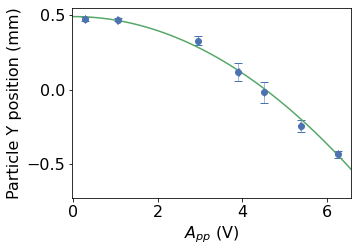

In [34]:
# X Fittings
# Linear 
parameters=[0.5,14]
varx, dvarx = optimize.curve_fit(lin,V_avg[0][2:], X_avg[0][2:]*1e6, parameters, sigma=X_avg[1][2:]*1e6)
errx = np.sqrt(np.diag(dvarx)) #std of vary
print(f'parameters:{varx}')
print(f'error: {errx}')
mx,bx=varx[0],varx[1]
# Quadratic
qx, dqx = optimize.curve_fit(quad,V_avg[0][:], X_avg[0][:]*1e6, [5e-2,15], sigma=X_avg[1][:]*1e6)
aqx, bqx = qx[0], qx[1]

# X Plots
plt.figure(figsize=(5,3.5))
plt.errorbar(V_avg[0],X_avg[0]*1e6,xerr=V_avg[1],yerr=X_avg[1]*1e6,fmt='o',lw=.5,capsize=4,**colors_thesis[0])
plt.xlim(plt.xlim())
#plt.plot(np.linspace(2,7,10),lin(np.array(np.linspace(2,7,10)),mx,bx),**colors_thesis[1],label='Fit')
plt.plot(np.linspace(0,7,50),quad(np.array(np.linspace(0,7,50)),aqx,bqx),**colors_thesis[1],label='qFit')
plt.xlabel('$A_{pp}$ (V)')
plt.ylabel('Particle X position ($\mu$m)')
plt.savefig(f'XvsVpp_q.pdf', bbox_inches='tight')
plt.show()

# Y Fittings
vary, dvary = optimize.curve_fit(lin,V_avg[0][2:],Y_avg[0][2:]*1e3,parameters,sigma=Y_avg[1][2:]*1e3)
erry = np.sqrt(np.diag(dvary)) #std of vary
print(f'parameters:{vary}')
print(f'error: {erry}')
my,by=vary[0],vary[1]

qy, dqy = optimize.curve_fit(quad,V_avg[0][:], Y_avg[0][:]*1e3, [-5,7], sigma=Y_avg[1][:]*1e3)
aqy, bqy = qy[0], qy[1]

plt.figure(figsize=(5,3.5))
plt.errorbar(V_avg[0],Y_avg[0]*1e3,xerr=V_avg[1],yerr=Y_avg[1]*1e3,fmt='o',lw=.5,capsize=4,**colors_thesis[0])
plt.xlim(plt.xlim())
#plt.plot(np.linspace(2,7,10),lin(np.array(np.linspace(2,7,10)),my,by),**colors_thesis[1],label='Fit')
plt.plot(np.linspace(0,7,50),quad(np.array(np.linspace(0,7,50)),aqy,bqy),**colors_thesis[1],label='qFit')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(-1,1))
plt.xlabel('$A_{pp}$ (V)')
plt.ylabel('Particle Y position (mm)')
plt.savefig(f'YvsVpp_q.pdf', bbox_inches='tight')
plt.show()

In [495]:
print(Y_avg[0])
print(V_avg[0])

[ 4.72138493e-04  4.66668537e-04  3.26615776e-04  1.15727079e-04
 -1.74262268e-05 -2.42571181e-04 -4.31834494e-04]
[0.26719586 1.05431397 2.94923509 3.90965661 4.5214868  5.38233782
 6.26821849]


## Angular momentum: 
The particle's rotation seems to be inscripted in the SUM measurment. More specifically, the rotation frequency should be correlated to some frequency in the SUM signal.
Also the rotation frecuency seems to be correlated with the amplitud (or VPP) of the AT.

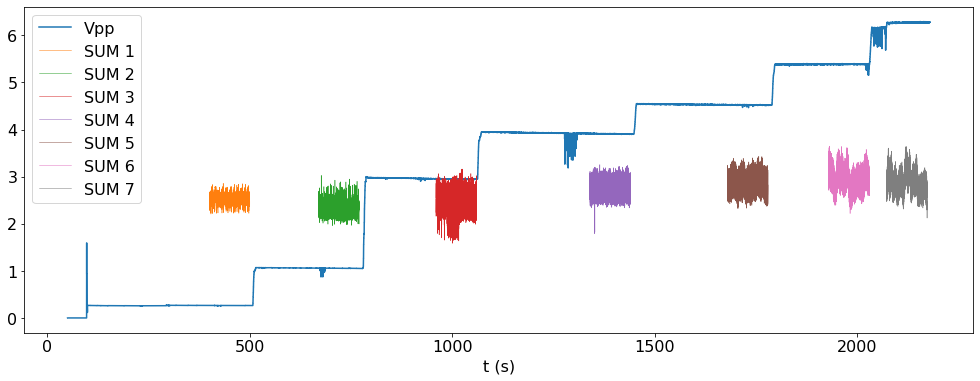

In [46]:
#Watching changes in frecuency vs Vpp (bathces)

plt.figure(figsize=(17, 6))
df["Vpp (V)"].plot(label='Vpp')
# Plot batches 
for bch in range(np.shape(batch_idx)[0]): #plot batch data with a shift
    plt.plot(V_batches[3][bch]+0.3E-3,label=f'SUM {bch+1}', linewidth=0.5) #batches data
plt.legend(loc='upper left')
plt.show()

### Power spectrum
We compute the power spectral density (PSD) to see if information of the frequencies can be extracted from the V=cte sections.
The PSD can be given by the module squared of the fourier transform of the signal. 

https://en.wikipedia.org/wiki/Spectral_density

https://mark-kramer.github.io/Case-Studies-Python/03.html#supplement-acv

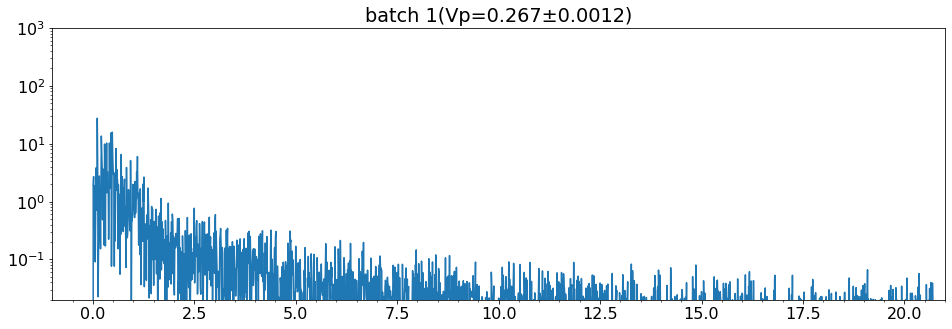

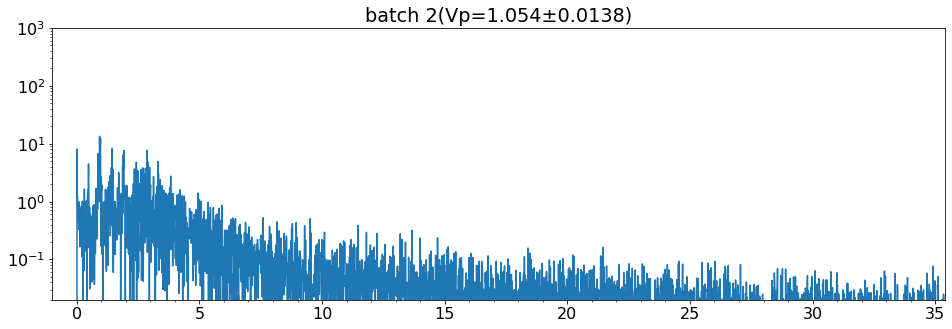

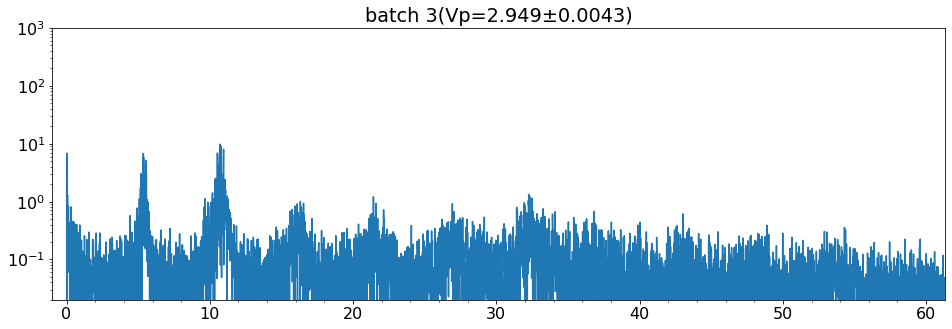

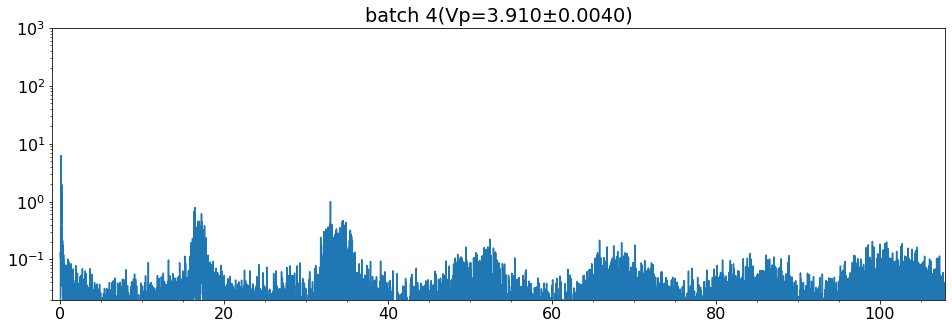

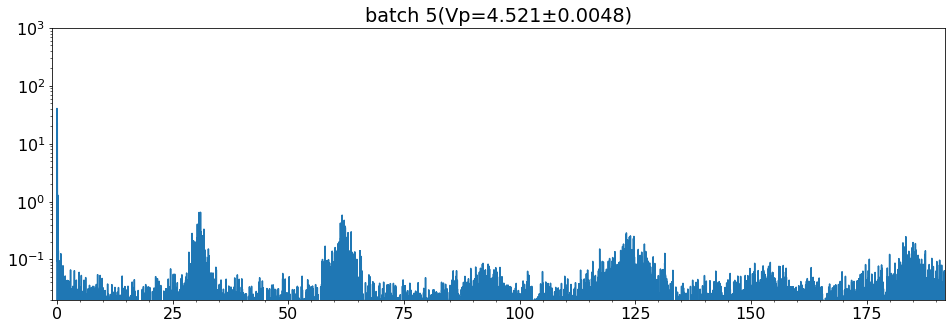

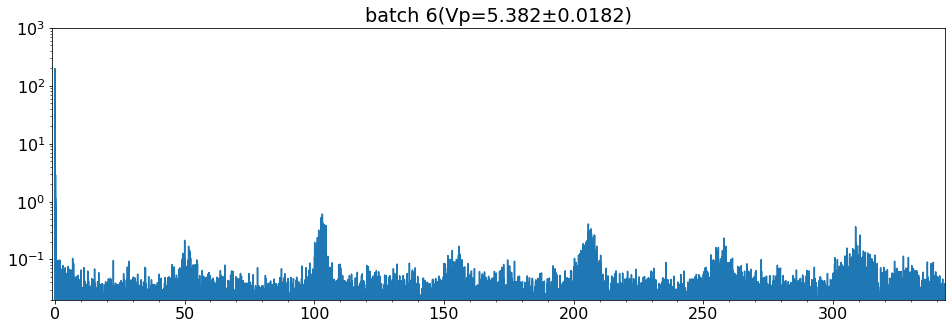

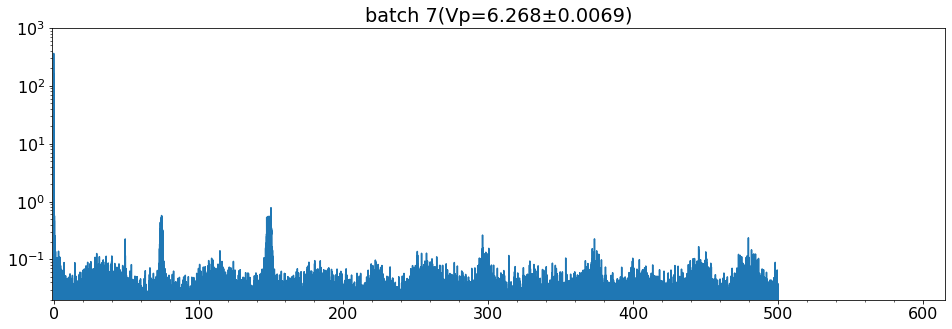

In [47]:
for batch in range(np.shape(batch_idx)[0]):
    data=V_batches[3][batch]
    n=len(data)
    fhat=np.fft.rfft(data-np.mean(data))      #Compute the fft
    PSD=(fhat*np.conj(fhat)/n).real                #Power spectrum (power per f..
    freq=np.linspace(0,sps/2,n//2) #(sps/n)*np.arange(n,sps)    #Create x-axis of frequencies 
    L=np.arange(0,n//2,dtype='int')

    plt.figure(figsize=(16,5))
    plt.title(f'batch {batch+1}(Vp={np.mean(V_batches[2][batch]):.3f}±{np.std(V_batches[2][batch]):.4f})')
    plt.semilogy(freq[L],PSD[L]) #plotting in logarithm scale
    plt.xlim(-1,10*1.8**(batch+1)+3)
    plt.ylim(20E-3,10E2)
    plt.minorticks_on()

In [48]:
def high_envelopes_idx(s,dmax=1): #For plotting only the amplitud (upper envelope) of a signal
    """
    s : 1d-array, data signal from which to extract high envelope
    dmax : int, size of chunks, use this if size of data is too big
    example:
            a                 = 2,3,4,-1,-1,-1,1,0
            diff(a)            = 1,1,-5,0,0,2,-1
            sign(diff(a))      = 1,1,-1,0,0,1,-1
            diff(sign(diff(a))) = 0,-2,1,0,1,-2  -> <0 are maximma
    """
    # local maxs
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 

    # Take into account only the peaks above the mean
    s_mid = np.mean(s) #(0 if s centered or more generally mean of signal)
    lmax = lmax[s[lmax]>s_mid]
    
    # Keep one of every dmax??
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    return lmax

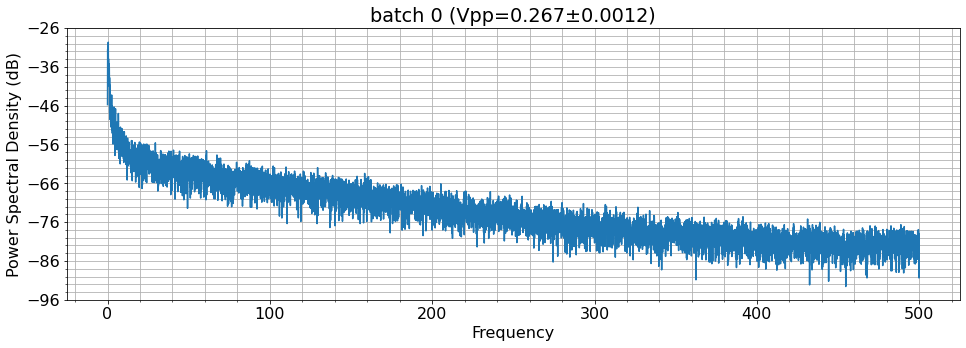

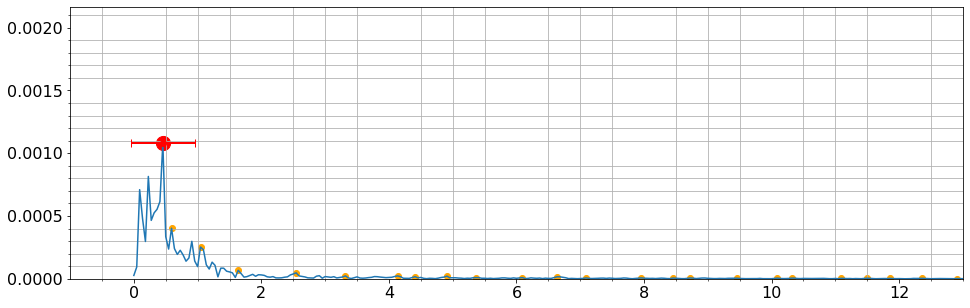

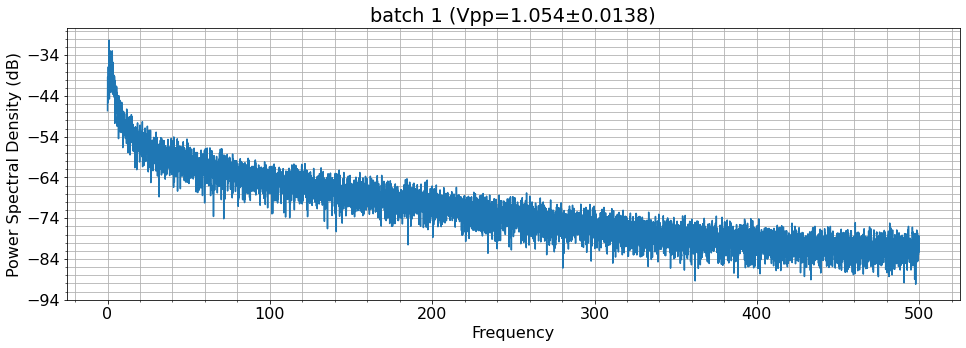

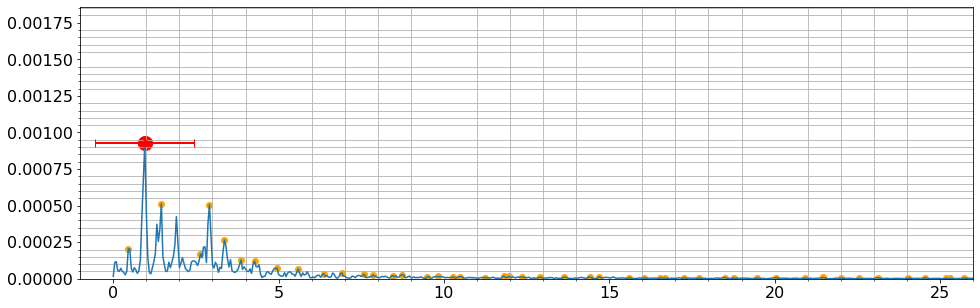

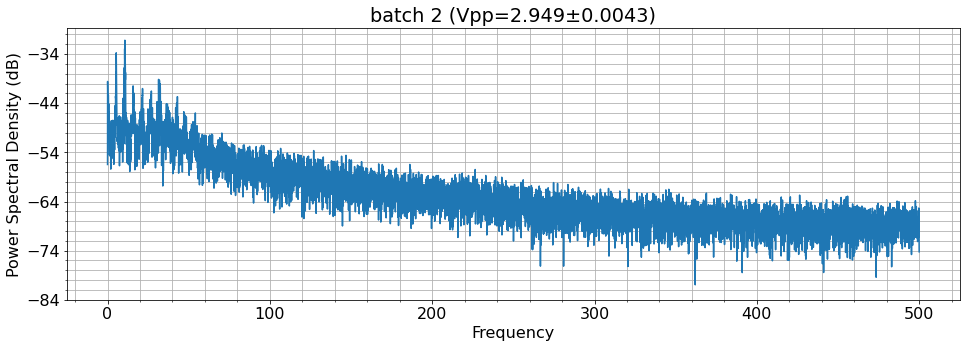

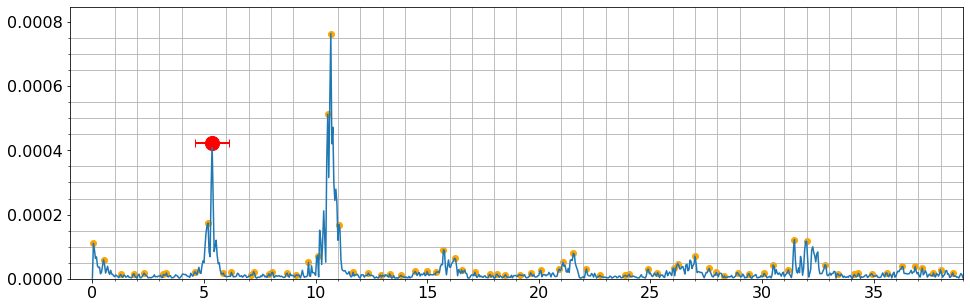

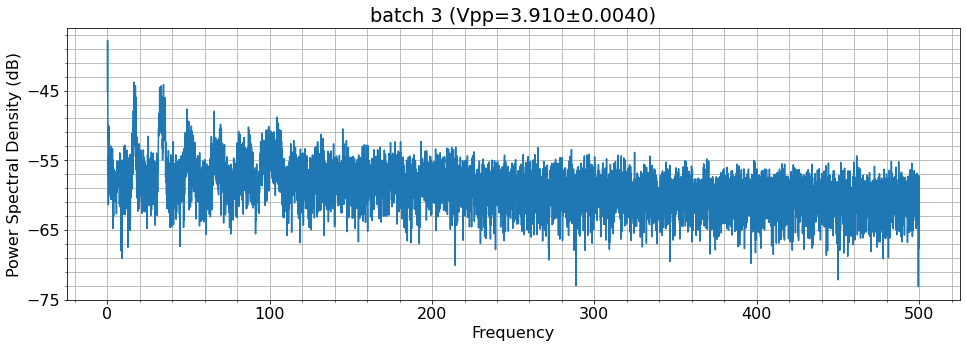

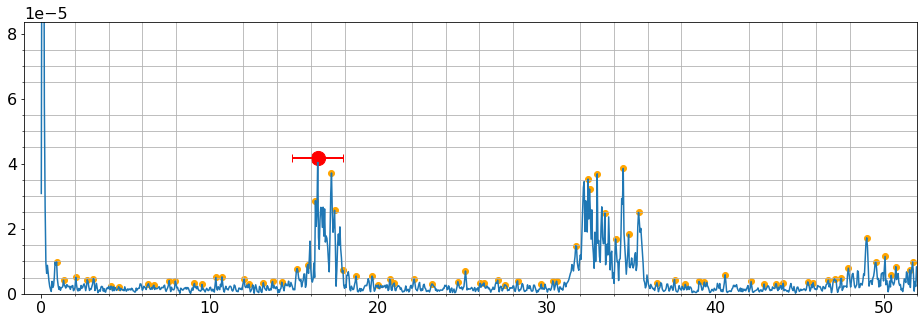

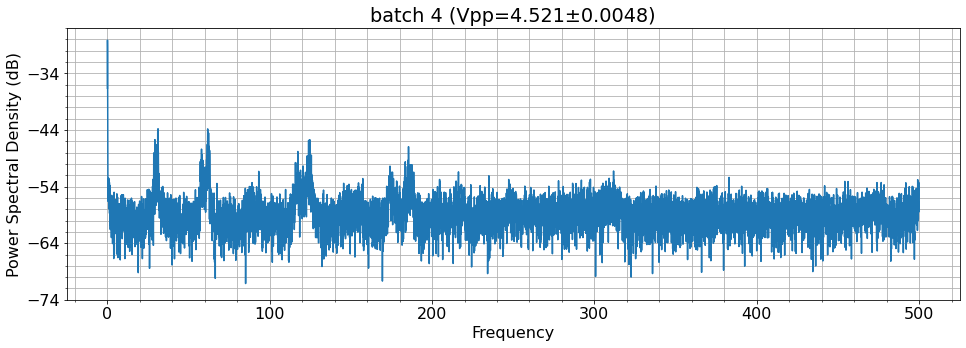

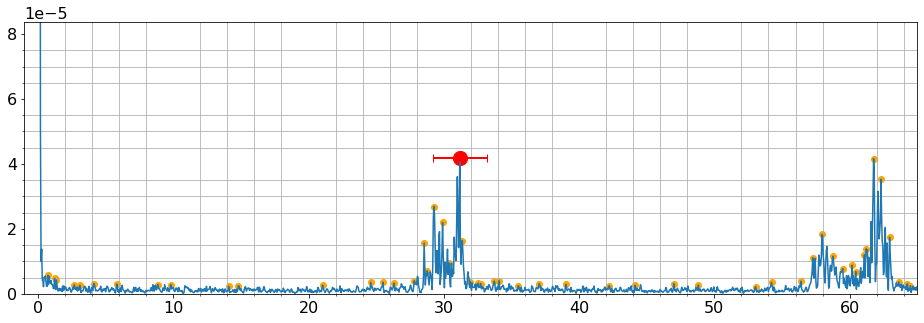

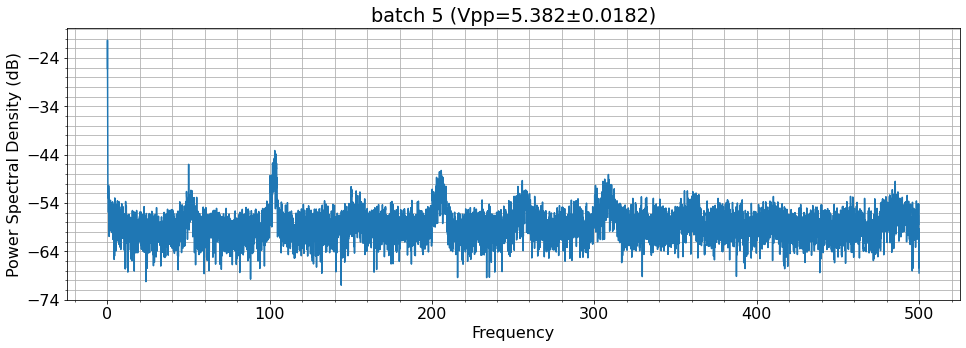

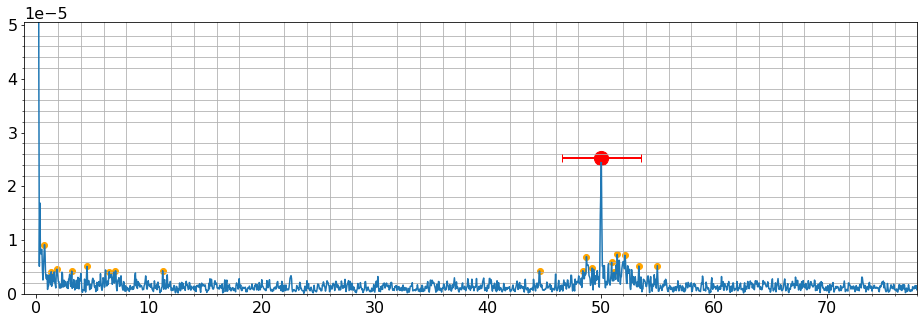

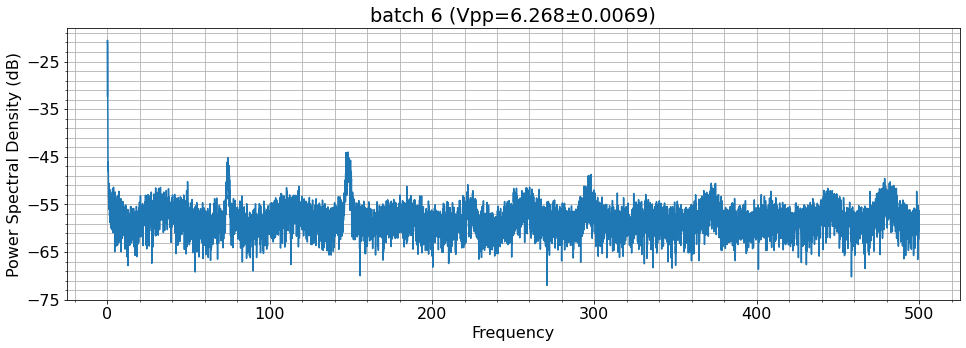

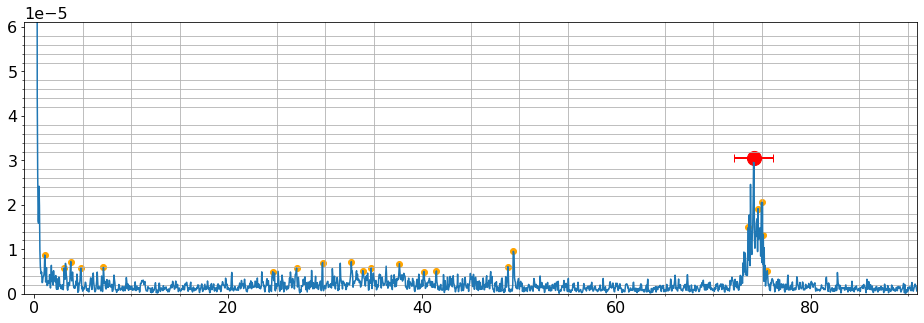

In [646]:
# Obtaining the peaks of PSD
pkfreqs = []
pkbatch = []
pkvals = []
for batch in range(np.shape(batch_idx)[0]):
    n=len(V_batches[3][batch])
    plt.figure(figsize=(16,5))
    # Plot and obtain PSD 
    PSD, freq = plt.psd(V_batches[3][batch],22000,Fs=sps,detrend="mean",scale_by_freq=False);
    plt.title(f'batch {batch} (Vpp={np.mean(V_batches[2][batch]):.3f}±{np.std(V_batches[2][batch]):.4f})')
    #plt.xlim(-1,13*(batch+1))
    plt.minorticks_on()
    plt.grid(which="minor")
    plt.show()

    # Plot again from data and MARK PEAKS
    highidx = high_envelopes_idx(PSD,dmax=3)
    plt.figure(figsize=(16,5))
    plt.plot(freq,PSD)
    # Mark peaks
    plt.scatter(freq[highidx], PSD[highidx], color='orange') # Many
    plt.scatter(peaks_df.iloc[rot_freq_idx[batch],1], peaks_df.iloc[rot_freq_idx[batch],2], s=200, color='red') # First order (Defined in next cells)
    plt.errorbar(peaks_df.iloc[rot_freq_idx[batch],1], peaks_df.iloc[rot_freq_idx[batch],2],xerr=rot_err[batch], fmt='o',lw=2,capsize=4,color='red')
        
    # Adjust scale of plots with 
    plt.xlim(-1,13*(batch+1))
    plt.ylim(0,peaks_df.iloc[rot_freq_idx[batch],2]*2)
    plt.minorticks_on()
    plt.grid(which="minor")
    plt.show()
    
    #Save peaks data
    pkfreqs.append(freq[highidx])
    pkvals.append(PSD[highidx])
    pkbatch.append(np.full(len(freq[highidx]), batch))


In [52]:
peaks_df = pd.DataFrame({'batch':np.concatenate(pkbatch), 'freq':np.concatenate(pkfreqs), 'PSD':np.concatenate(pkvals)})

In [53]:
pd.options.display.float_format = "{:,.4f}".format
# Manual selection of the "first order" peaks
print("Top highest peaks per batch:")
for batch in range(2,np.shape(batch_idx)[0]):
        print(peaks_df[peaks_df["batch"]==batch].sort_values("PSD", ascending=False).iloc[0:7,:])
rot_freq_idx = [0,64,148,346,833,1259,1430] # indexes of selected peaks
rot_err = [0.5,1.5,0.75,1.5,2,3.5,2] # Estimated error (from observing hills)

Top highest peaks per batch:
     batch    freq    PSD
160      2 10.6818 0.0008
159      2 10.5455 0.0005
148      2  5.3636 0.0004
147      2  5.1818 0.0002
161      2 11.0455 0.0002
200      2 31.4545 0.0001
201      2 32.0000 0.0001
     batch    freq    PSD
322      3  0.0909 0.0002
346      3 16.4091 0.0000
373      3 34.5455 0.0000
347      3 17.2273 0.0000
370      3 33.0000 0.0000
368      3 32.4545 0.0000
369      3 32.5455 0.0000
     batch     freq    PSD
811      4   0.0455 0.0015
833      4  31.1818 0.0000
858      4  61.7727 0.0000
859      4  62.3182 0.0000
830      4  29.2727 0.0000
914      4 124.6818 0.0000
912      4 123.9545 0.0000
      batch     freq    PSD
1246      5   0.0455 0.0093
1273      5 103.0909 0.0000
1274      5 103.7273 0.0000
1271      5 101.7727 0.0000
1275      5 104.1818 0.0000
1259      5  50.0455 0.0000
1272      5 102.1818 0.0000
      batch     freq    PSD
1412      6   0.0455 0.0088
1446      6 148.2273 0.0000
1444      6 147.0000 0.0000
144

In [56]:
rot_freq = peaks_df.iloc[rot_freq_idx,1]
print(rot_freq)

print(V_avg)

0       0.4545
64      0.9545
148     5.3636
346    16.4091
833    31.1818
1259   50.0455
1430   74.1364
Name: freq, dtype: float64
[array([0.26719586, 1.05431397, 2.94923509, 3.90965661, 4.5214868 ,
       5.38233782, 6.26821849]), array([0.00120385, 0.01379329, 0.00431565, 0.00395367, 0.00483991,
       0.01818244, 0.00685277])]


In [57]:
def expn(x,a,b):
    return a*x**2+bx**3

In [72]:
def pot(x,a,b):
    return a*x**(b)

exp parameters:[1.39615794 0.64099061]
exp error: [0.53162862 0.06362831]
pot parameters:[0.20657022 3.21605238]
pol parameters:[0.06311749 0.17513346]


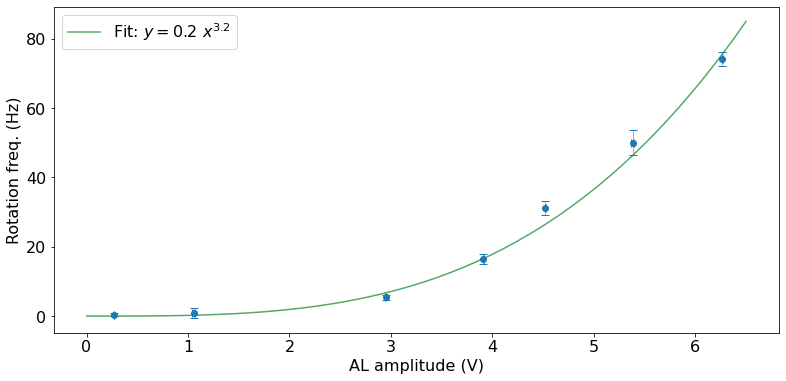

The error bars are estimated from the PSD plots


In [644]:
parameters = [2,1]
vare, dvare = optimize.curve_fit(expn, V_avg[0], rot_freq, parameters, sigma=rot_err)
erre = np.sqrt(np.diag(dvare)) #std of vary
varp, dvarp = optimize.curve_fit(pot,V_avg[0], rot_freq, parameters, sigma=rot_err)
errp = np.sqrt(np.diag(dvarp)) #std of vary
print(f'exp parameters:{vare}\nexp error: {erre}')
print(f'pot parameters:{varp}\npol parameters:{errp}')
ae,be = vare[0],vare[1]
ap,bp = varp[0],varp[1]

plt.figure(figsize=(13,6))
#plt.plot(np.linspace(0,6.5),expn(np.array(np.linspace(0,6.5)),ae,be),**colors_thesis[2],label='exp fit')
plt.plot(np.linspace(0,6.5),pot(np.array(np.linspace(0,6.5)),ap,bp),**colors_thesis[1],label=f'Fit: $y=${ap:.1f} $x ^{{3.2}}$')
plt.errorbar(V_avg[0], rot_freq, xerr=V_avg[1], yerr=rot_err, fmt='o', lw=.5, capsize=4) 
plt.legend()
#plt.title("Response in the rotation frequency")
plt.xlabel("AL amplitude (V)")
plt.ylabel("Rotation freq. (Hz)")
#plt.grid(which="major")
plt.savefig(f'AM_plots/fvsVpp.pdf', bbox_inches='tight')
plt.show()
print("The error bars are estimated from the PSD plots")


### TESTS

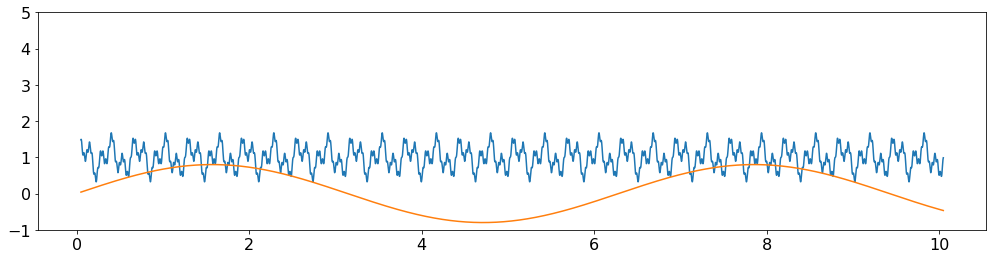

(-0.44994999999999996, 10.54895, -0.6196940840043185, 2.6199494294024577)

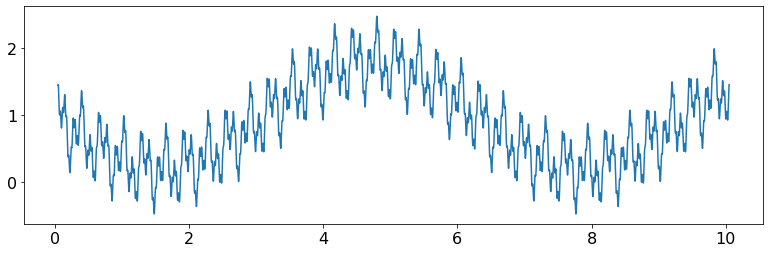

In [88]:
t=df0.index
plt.figure(figsize=(17, 4))
f=0.3*np.sin(20*t[ini:ini+10000])+0.3*np.sin(50*t[ini:ini+10000])-0.1*np.sin(200*t[ini:ini+10000])+1
g=0.8*np.sin(t[ini:ini+10000])
plt.plot(t[ini:ini+10000],f,t[ini:ini+10000],g)
plt.ylim([-1,5])
axs=plt.axis()
plt.show()
plt.figure(figsize=(17, 4))
plt.plot(t[ini:ini+10000],f-g)
plt.axis('scaled')
#axes.set_aspect(6/110)

In [232]:
def high_envelopes_idx(s,dmax=1): #For plotting only the amplitud (upper envelope) of a signal
    """
    s : 1d-array, data signal from which to extract high envelope
    dmin, dmax : int, size of chunks, use this if size of data is too big
    """
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 

    # the following might help in some case by cutting the signal in "half"
    s_mid = np.mean(s) #(0 if s centered or more generally mean of signal)
    # pre-sort of local max based on sign 
    lmax = lmax[s[lmax]>s_mid]
    
    # global min of dmin-chunks of locals min 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    return lmax

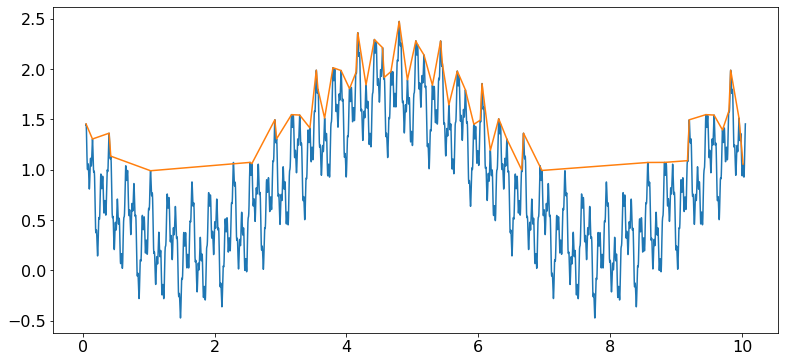

In [235]:
highidx = high_envelopes_idx(f-g,3)
plt.figure(figsize=(13,6))
plt.plot(t[ini:ini+10000],f-g)
plt.plot(t[ini+highidx],f[highidx]-g[highidx])
plt.show()

10000 (5001,)


/Users/pablohermun/opt/miniconda3/envs/tesis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 60.0)

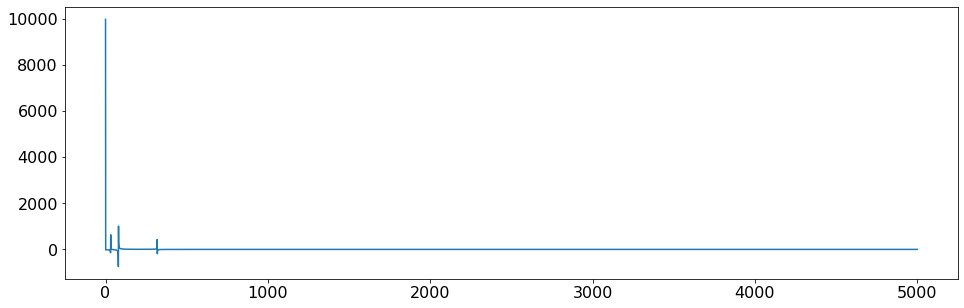

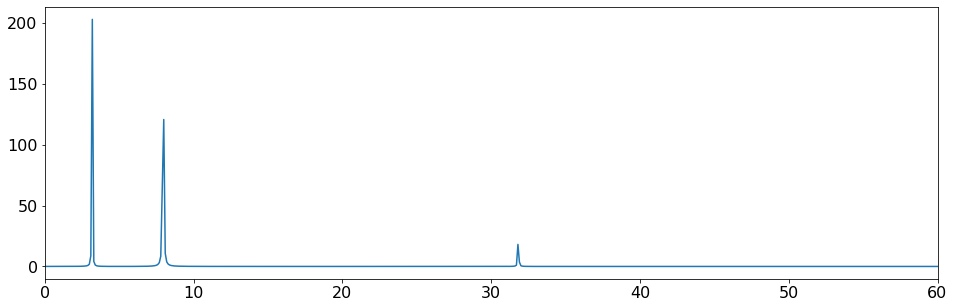

In [133]:
n = len(f)
PSD, freq = psd(f, sps, centre=False)             #Create x-axis of frequencies
L=np.arange(1,np.floor(n/2),dtype='int') #Only plot the first fraction (half) of...

print(len(f), np.shape
plt.figure(figsize=(16,5))
plt.plot(np.fft.rfft(f)) #plotting in logarithm scale

plt.figure(figsize=(16,5))
plt.plot(freq[L],PSD[L]) #plotting in logarithm scale
plt.xlim(0,60)
